# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.3716171.datarmor0/parcels-502027/libparcels_random_903452ba-f01e-465a-bbf4-b3501d8e0318.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.34:41685 Dashboard: http://10.148.1.34:8787/status,Cluster Workers: 14 Cores: 28 Memory: 119.98 GB


________
# 1. Read LLC4320 spectra

In [4]:
# load spectra

root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
ds_L = (p.load_diagnostic('spectra_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_lat.zarr'))
        .rename({'E_SSUV': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds = xr.merge([ds_L, ds_E])
ds

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

# 2. Read Drifter spectra

In [5]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_raw = xr.open_zarr(data_dir+'E_drifter_raw.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window
E_drifter = E_drifter.assign_coords(lat=E_drifter.lat_bins) 
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
E_drifter_interp = E_drifter.interp(lat_bins = ds.lat,freq_time= ds.frequency/86400)
E_drifter_interp

<xarray.DataArray 'E_drifter_linear_window' (lat: 119, frequency: 1440)>
dask.array<dask_aware_interpnd, shape=(119, 1440), dtype=float64, chunksize=(119, 1440), chunktype=numpy.ndarray>
Coordinates:
    freq_cpd           (frequency) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    freq_time_spacing  float64 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    freq_time          (frequency) float64 -0.0001389 -0.0001387 ... 0.0001387
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98

# 3. Previous LLC4320

In [7]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds_llc4320 = xr.concat(D, dim='face')
E = (ds_llc4320.E*ds_llc4320.A).sum(dim='face') / ds_llc4320.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E_llc4320_interp = E.interp(lat = ds.lat,freq_time= ds.frequency/86400)
print(E_llc4320_interp)
df=E.freq_time[1]-E.freq_time[0]
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi

<xarray.DataArray (lat: 119, frequency: 1440)>
dask.array<dask_aware_interpnd, shape=(119, 1440), dtype=float64, chunksize=(119, 1440), chunktype=numpy.ndarray>
Coordinates:
    freq_cpd   (frequency) float64 nan -11.98 -11.97 -11.95 ... 11.95 11.97 nan
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
    freq_time  (frequency) float64 -0.0001389 -0.0001387 ... 0.0001385 0.0001387
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98


Text(0.5, 1.0, 'Drifter (drogued)')

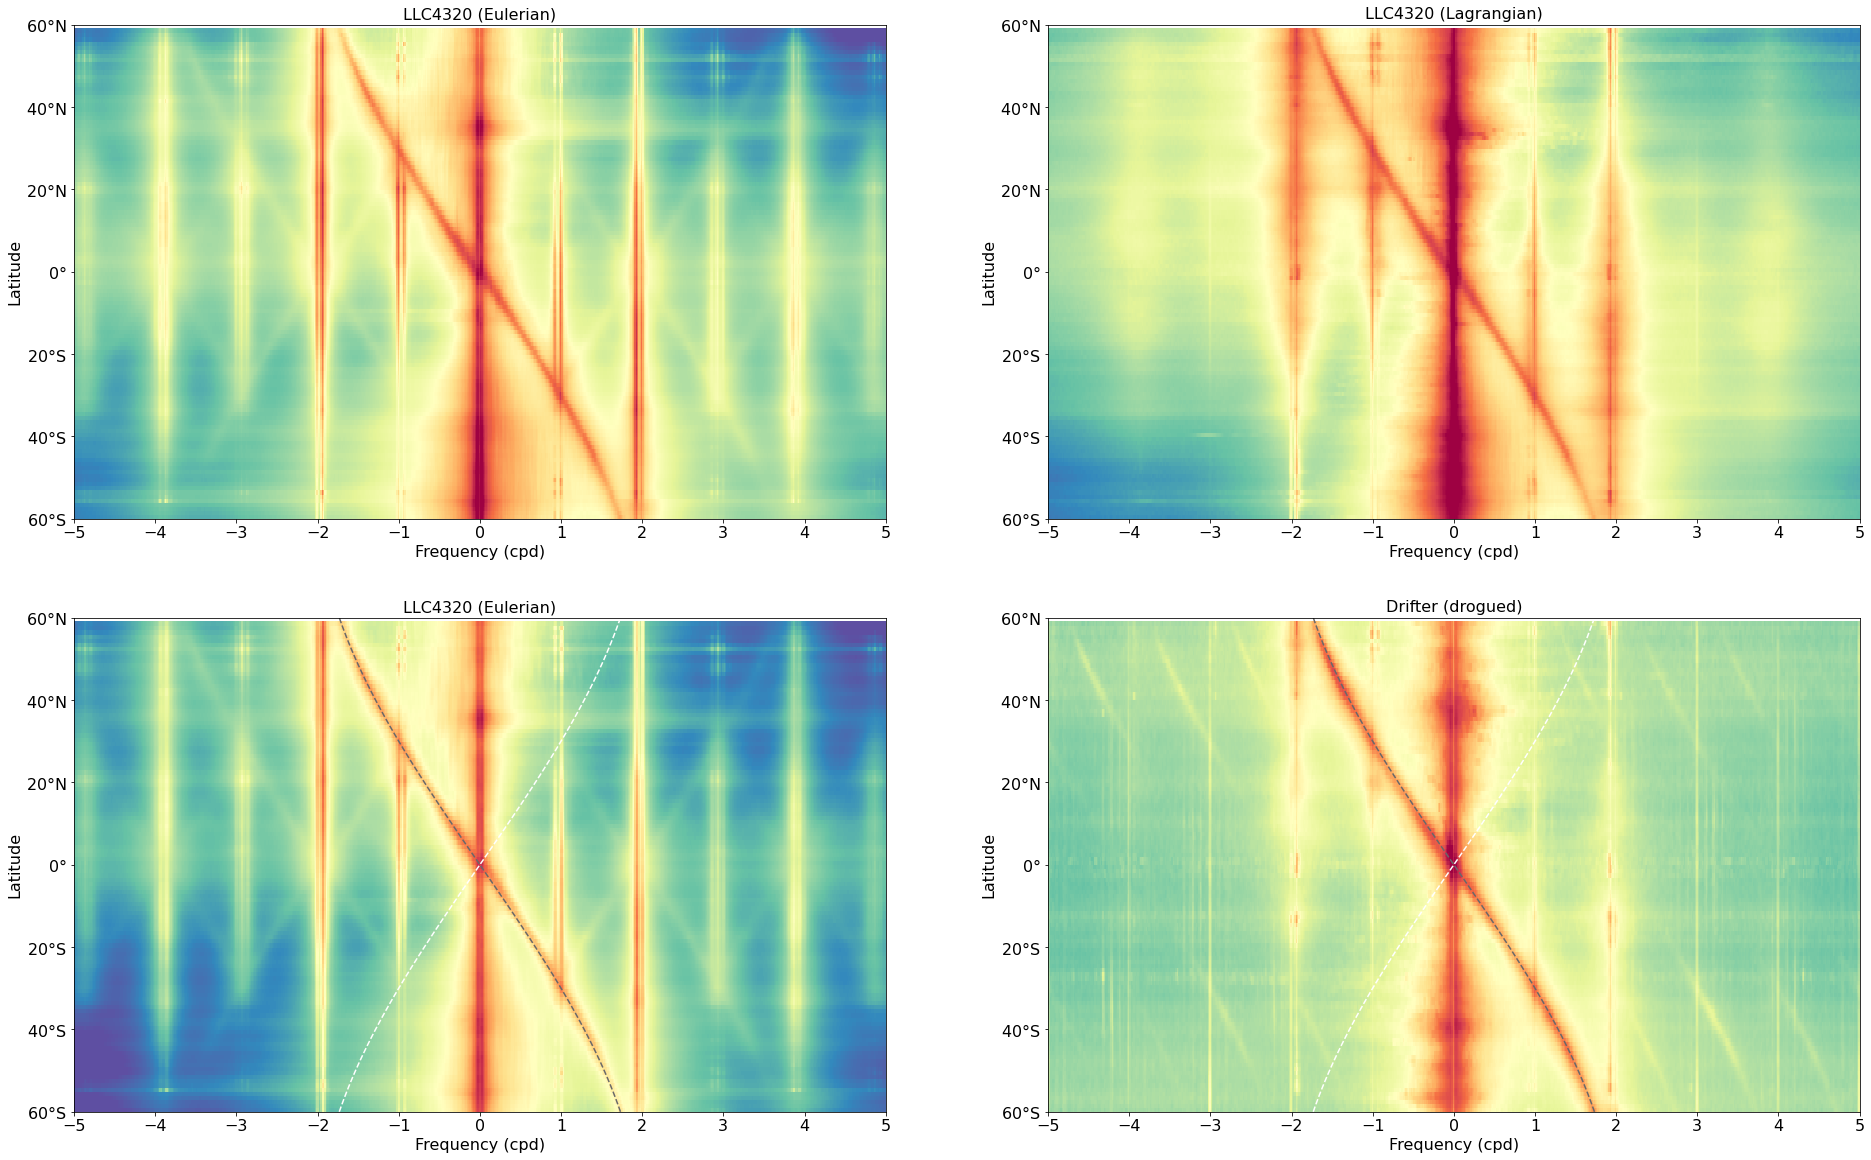

In [9]:
font_size = 16

fig, ax = plt.subplots(figsize=(32,20))


# LLC4320
ax = plt.subplot(2,2,1)
cax = np.log10(ds['E_Eulerian']*86400/6).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)


# Drifters
ax = plt.subplot(2,2,2)
cax = np.log10(ds['E_Lagrangian']*86400/6).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian)',fontsize=font_size)


# Drifters
ax = plt.subplot(2,2,3)
cax = np.log10(E_llc4320_interp/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)


# Drifters
ax = plt.subplot(2,2,4)
cax = np.log10(E_drifter_interp/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('Drifter (drogued)',fontsize=font_size)


Text(0.5, 1.0, 'LLC4320 (Eulerian)/LLC4320 (Eulerian)')

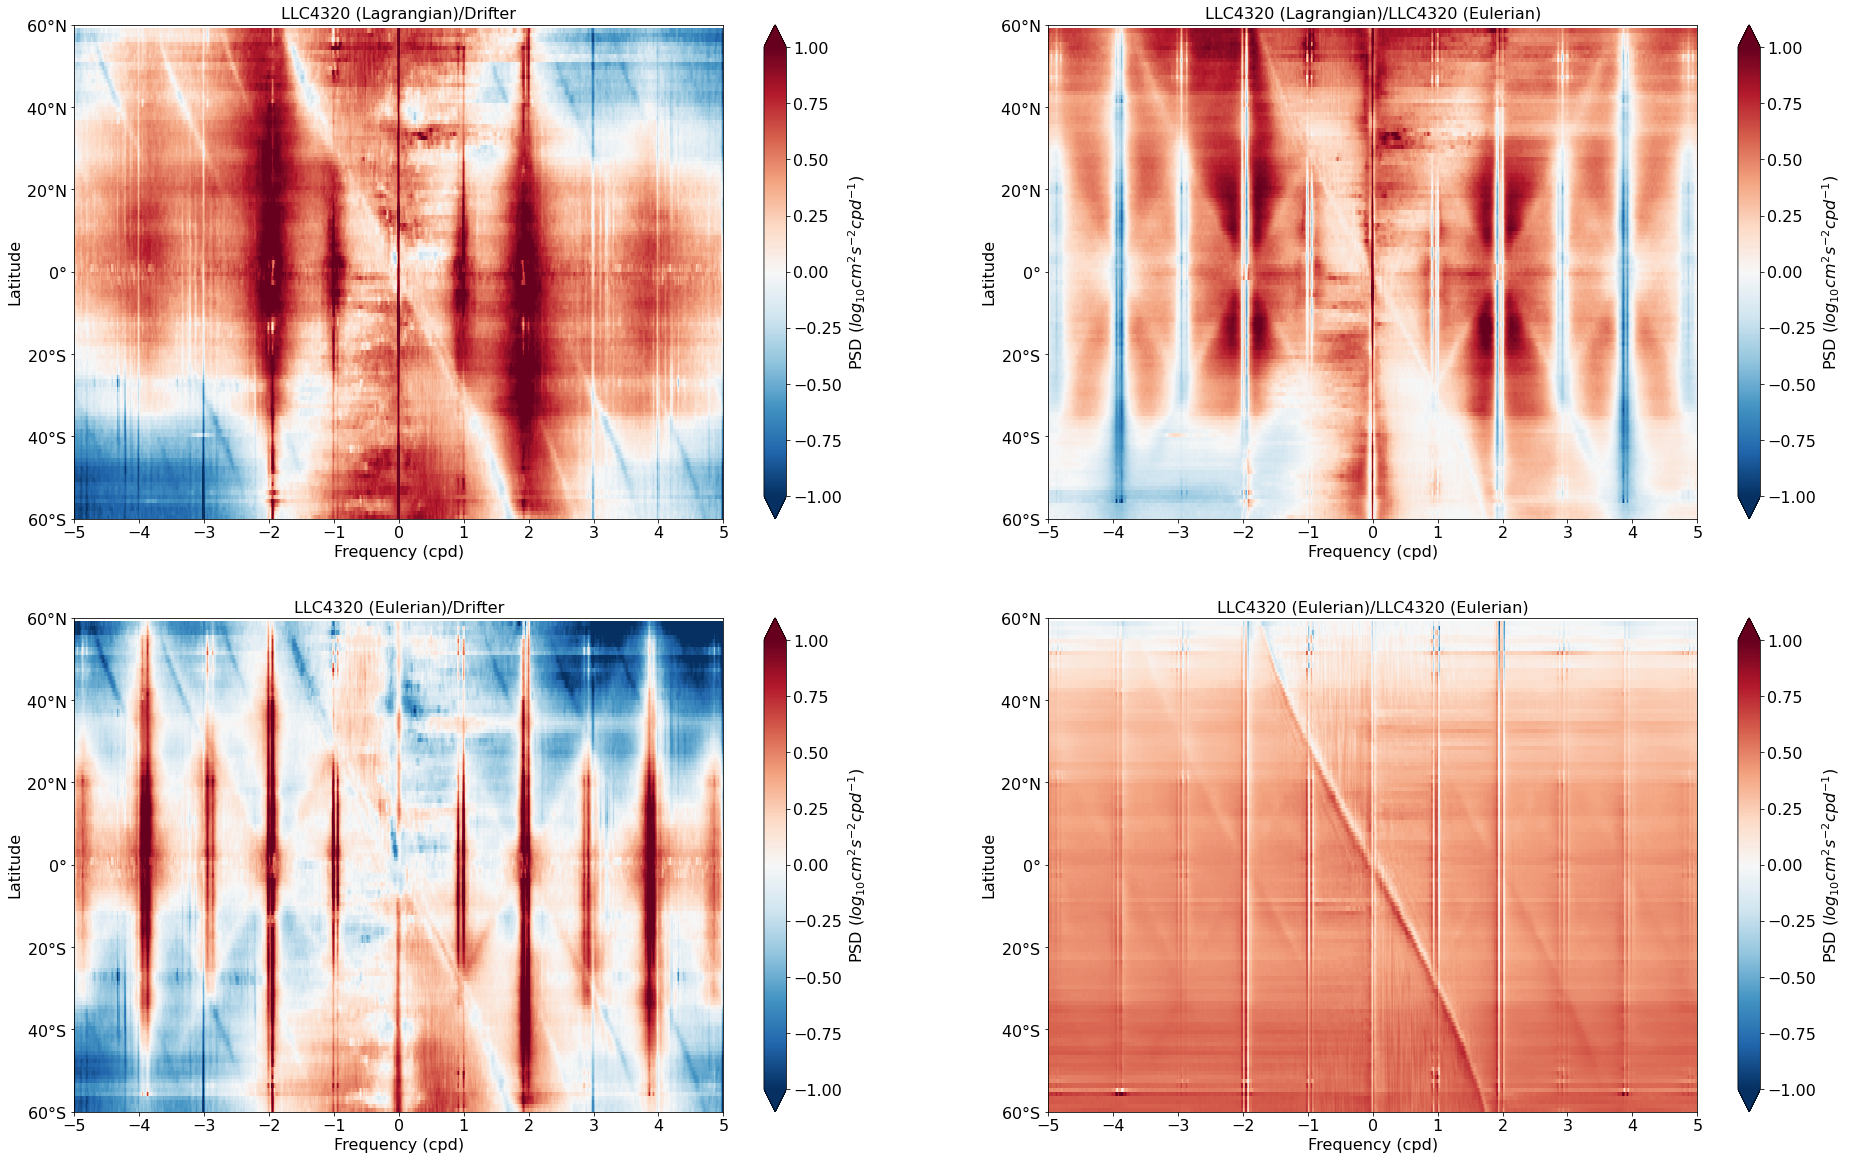

In [14]:
font_size = 16

fig, ax = plt.subplots(figsize=(32,20))


ax = plt.subplot(2,2,1)
cax = np.log10(ds['E_Lagrangian']*86400/6/(E_drifter_interp.sortby('freq_time')/8.64)).plot.pcolormesh(ax=ax, x='frequency', y='lat', vmin=-1, vmax=1, cmap = 'RdBu_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Lagrangian)/Drifter',fontsize=font_size)


ax = plt.subplot(2,2,2)
cax = np.log10(ds['E_Lagrangian']/ds['E_Eulerian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', vmin=-1, vmax=1, cmap = 'RdBu_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Lagrangian)/LLC4320 (Eulerian)',fontsize=font_size)


ax = plt.subplot(2,2,3)
cax = np.log10(ds['E_Eulerian']*86400/6/(E_drifter_interp.sortby('freq_time')/8.64)).plot.pcolormesh(ax=ax, x='frequency', y='lat', vmin=-1, vmax=1, cmap = 'RdBu_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Eulerian)/Drifter',fontsize=font_size)


ax = plt.subplot(2,2,4)
cax = np.log10(ds['E_Eulerian']*86400/6/(E_llc4320_interp.sortby('freq_time')/8.64)).plot.pcolormesh(ax=ax, x='frequency', y='lat', vmin=-1, vmax=1, cmap = 'RdBu_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Eulerian)/LLC4320 (Eulerian)',fontsize=font_size)

## Close cluster

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
